In [5]:
# 设置环境变量
import os
# os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
# 导入库
import torch
import blobfile as bf
import transformer_lens
import sparse_autoencoder
from utils import *
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
model, device = load_model("gpt2")
layer_index = 6
location = "resid_post_mlp"
autoencoder = load_autoencoder(location, layer_index, device, 128)

Loaded pretrained model gpt2 into HookedTransformer
az://openaipublic/sparse-autoencoder/gpt2-small/resid_post_mlp_v5_128k/autoencoders/6.pt


In [7]:
def feature_steering(autoencoder,x: torch.Tensor, feature_indices: list[int], feature_values: list[float]) -> torch.Tensor:
    assert len(feature_indices) == len(feature_values), "Feature indices and values must have the same length."
    feature_values = [max(min(value, 10), -10) for value in feature_values]

    with torch.no_grad():
        # 获取原始特征表示和信息
        latents, info = autoencoder.encode(x)
        # 修改特征表示
        for index, value in zip(feature_indices, feature_values):
            if feature_values > 0:
                latents[:, index] = latents[:, index] * value
            else:
                latents[:, index] = latents[:, index] / value
            print(f"Feature {index} modified with {'+' if value >= 0 else ''}{value}")
        # 使用修改后的特征表示通过解码器生成重构输出
        modified_output = autoencoder.decode(latents, info)
    return modified_output



def compare_activations(tensor1, tensor2):
    difference = tensor1 - tensor2
    print("Difference between tensors:\n", difference)

    # 计算差异的统计信息
    mean_diff = torch.mean(difference)
    std_diff = torch.std(difference)
    print(f"Mean difference: {mean_diff.item()}")
    print(f"Standard deviation of difference: {std_diff.item()}")

    # 可视化差异
    difference_np = difference.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(difference_np, cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Difference')
    plt.title('Difference between Reconstructed Activations and Modified Output')
    plt.xlabel('Feature Index')
    plt.ylabel('Sample Index')
    plt.show()

In [8]:
prompt = "This is an example of a prompt that"
feature_indices = [53912]
feature_values = [10] 
tokens_id, tokens_str, activation_cache = process_input(model, prompt)
activation = get_activation(activation_cache, layer_index)

In [9]:
latent_activations, recon_activations = encode_decode(autoencoder, activation)

In [10]:
modified_recon_activations = feature_steering(autoencoder, activation, feature_indices, feature_values)

Feature 53912 modified with +10


Difference between tensors:
 tensor([[-3.8607e+01,  2.8522e+01,  4.1739e-01,  ...,  6.1684e+00,
         -1.1601e+02, -4.9221e+01],
        [-1.1621e+00,  8.5856e-01,  1.2564e-02,  ...,  1.8568e-01,
         -3.4921e+00, -1.4817e+00],
        [-1.1133e+00,  8.2245e-01,  1.2036e-02,  ...,  1.7787e-01,
         -3.3452e+00, -1.4194e+00],
        ...,
        [-1.0007e+00,  7.3928e-01,  1.0819e-02,  ...,  1.5989e-01,
         -3.0070e+00, -1.2758e+00],
        [-1.2634e+00,  9.3335e-01,  1.3659e-02,  ...,  2.0186e-01,
         -3.7963e+00, -1.6107e+00],
        [-1.1306e+00,  8.3523e-01,  1.2223e-02,  ...,  1.8064e-01,
         -3.3972e+00, -1.4414e+00]])
Mean difference: 0.4899919331073761
Standard deviation of difference: 13.41736125946045


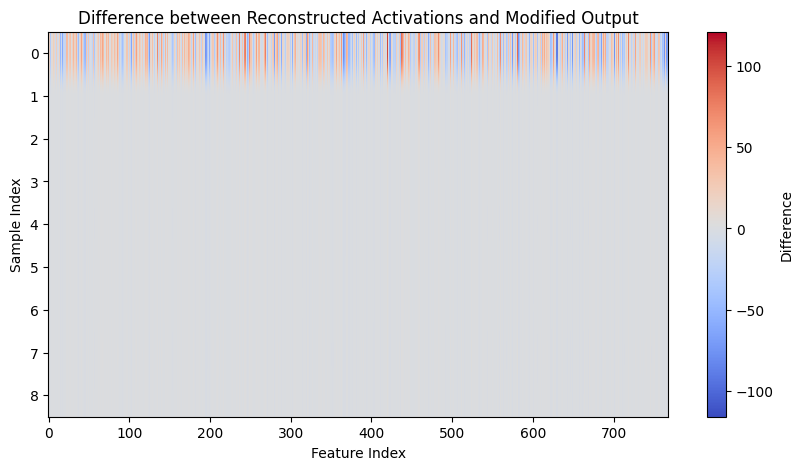

In [11]:
compare_activations(recon_activations, modified_recon_activations)